In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/Honors Program/honors/stocks

/content/drive/.shortcut-targets-by-id/15JtMaqUj0g0u5Rfig5mYfKaeRPqMjZ6o/honors/stocks


In [3]:
pip install baostock

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.2/55.2 kB 1.7 MB/s eta 0:00:00


In [4]:
# 处理数据
import numpy as np
import pandas as pd
# 获取股票数据
import baostock as bs

# 获取股票数据

In [5]:
def get_data(
        code="sh.000001", start_date="2017-07-01", end_date="2023-10-01", frequency="d"
):
    #### 登陆baostock系统 ####
    lg = bs.login()
    # 显示登陆返回信息
    print("登录响应代码:" + lg.error_code)
    print("登录响应信息:" + lg.error_msg)

    data = bs.query_history_k_data_plus(
        code,
        fields="date,code,open,high,low,close,volume",
        start_date=start_date,
        end_date=end_date,
        frequency="d",
        adjustflag="3",
    )
    data_list = []
    while (data.error_code == "0") & data.next():
        # 获取一条记录，将记录合并在一起
        data_list.append(data.get_row_data())
    # 转为dataframe
    result = pd.DataFrame(data_list, columns=data.fields)

    # 警惕：数据全是字符串：<class 'str'>
    # 把字符串转为数值
    result.open = result.open.astype("float64").round(2)
    result.close = result.close.astype("float64").round(2)
    result.high = result.high.astype("float64").round(2)
    result.low = result.low.astype("float64").round(2)
    result.volume = result.volume.astype("int")
    # date列转为时间类型
    result.date = pd.DatetimeIndex(result.date)

    # dataframe规范化
    df = pd.DataFrame(
        {
            "date":result["date"].values,
            "open": result["open"].values,
            "close": result["close"].values,
            "high": result["high"].values,
            "low": result["low"].values,
            "volume": result["volume"].values,
        }
    )

    #### 登出系统 ####
    bs.logout()
    return df

In [6]:
# 获取数据
data = get_data(code="sh.000001", start_date="2017-07-01", end_date="2023-10-01", frequency="d")

login success!
登录响应代码:0
登录响应信息:success
logout success!


In [7]:
# 计算股票回报
data.sort_values('date', inplace=True)
data['return'] = (data['close'] - data['close'].shift(1)) / data['close'].shift(1)

# 删除首行
data.dropna(subset=['return'], inplace=True)

In [8]:
data

,date,open,close,high,low,volume,return
1,2017-07-04,3192.89,3182.80,3193.06,3174.31,14111496704,-0.004102
2,2017-07-05,3179.22,3207.13,3207.31,3174.71,14829648384,0.007644
3,2017-07-06,3203.86,3212.44,3215.95,3188.77,17580928768,0.001656
4,2017-07-07,3203.82,3217.96,3219.52,3195.29,17671541504,0.001718
5,2017-07-10,3208.46,3212.63,3223.34,3203.21,19892801024,-0.001656
...,...,...,...,...,...,...,...
1517,2023-09-22,3084.76,3132.43,3132.56,3078.80,28597835100,0.015473
1518,2023-09-25,3131.21,3115.61,3131.21,3112.15,25807188500,-0.005370
1519,2023-09-26,3114.02,3102.27,3120.29,3102.27,22264431300,-0.004282
1520,2023-09-27,3104.04,3107.32,3125.45,3103.84,24049583000,0.001628


In [9]:
# 将日期列转换为日期时间格式
data['date'] = pd.to_datetime(data['date'])

# 按照年份和月份分组数据，并计算每个月的回报均值或总和
monthly_returns = data.groupby(data['date'].dt.to_period('M'))['return'].sum().reset_index()

In [10]:
monthly_returns

,date,return
0,2017-07,0.024155
1,2017-08,0.026970
2,2017-09,-0.003459
3,2017-10,0.013272
4,2017-11,-0.022197
...,...,...
70,2023-05,-0.035630
71,2023-06,-0.000286
72,2023-07,0.028159
73,2023-08,-0.052632


# 获得因子数据

In [ ]:
factors = pd.read_excel('/content/drive/MyDrive/Honors Program/honors/FinBERT/result_topics.xlsx')

In [ ]:
factors

,年份,月份,主题标签,negative,neutral,positive,总数,正面情绪百分比(%),中立情绪百分比(%),负面情绪百分比(%)
0,2017,7,-1,18,130,19,167,11.38,77.84,10.78
1,2017,7,0,4,7,0,11,0.00,63.64,36.36
2,2017,7,2,0,1,0,1,0.00,100.00,0.00
3,2017,7,3,0,2,2,4,50.00,50.00,0.00
4,2017,7,4,1,1,0,2,0.00,50.00,50.00
...,...,...,...,...,...,...,...,...,...,...
678,2023,9,5,0,7,1,8,12.50,87.50,0.00
679,2023,9,6,3,18,2,23,8.70,78.26,13.04
680,2023,9,7,0,1,1,2,50.00,50.00,0.00
681,2023,9,8,4,14,1,19,5.26,73.68,21.05


In [ ]:
# 创建一个新的DataFrame来存储重新构造后的数据
new_columns = ['年份', '月份']
new_columns.extend([f'正面情绪_{i}' for i in range(-1, 10)])
new_columns.extend([f'负面情绪_{i}' for i in range(-1, 10)])

factor_df = pd.DataFrame(columns=new_columns)

# 遍历每个月的数据，生成每年每个月的不同主题的情感比例
for year in factors['年份'].unique():
    for month in factors[factors['年份'] == year]['月份'].unique():
        new_row = {'年份': year, '月份': month}
        for i in range(-1, 10):
            pos_sum = factors[(factors['年份'] == year) & (factors['月份'] == month) & (factors['主题标签'] == i)]['positive'].sum()
            neg_sum = factors[(factors['年份'] == year) & (factors['月份'] == month) & (factors['主题标签'] == i)]['negative'].sum()
            total = factors[(factors['年份'] == year) & (factors['月份'] == month) & (factors['主题标签'] == i)]['总数'].sum()
            new_row[f'正面情绪_{i}'] = pos_sum / total if total != 0 else 0
            new_row[f'负面情绪_{i}'] = neg_sum / total if total != 0 else 0
        factor_df = factor_df.append(new_row, ignore_index=True)

In [ ]:
factor_df

,年份,月份,正面情绪_-1,正面情绪_0,正面情绪_1,正面情绪_2,正面情绪_3,正面情绪_4,正面情绪_5,正面情绪_6,...,负面情绪_0,负面情绪_1,负面情绪_2,负面情绪_3,负面情绪_4,负面情绪_5,负面情绪_6,负面情绪_7,负面情绪_8,负面情绪_9
0,2017.0,7.0,0.113772,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,...,0.363636,0.000000,0.000000,0.000000,0.500000,1.000000,0.000000,0.00,0.000000,0.000000
1,2017.0,8.0,0.106700,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.062500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000
2,2017.0,9.0,0.154054,0.076923,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,...,0.076923,0.000000,0.142857,0.000000,0.000000,0.500000,0.200000,0.00,0.000000,0.000000
3,2017.0,10.0,0.154386,0.181818,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.045455,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000
4,2017.0,11.0,0.159204,0.045455,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.090909,0.000000,0.000000,0.000000,0.000000,0.000000,0.400000,0.00,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,2023.0,5.0,0.095685,0.128472,0.090226,0.098214,0.500000,0.062500,0.000000,0.166667,...,0.072917,0.067669,0.071429,0.148148,0.250000,0.125000,0.166667,0.25,0.034483,0.218750
71,2023.0,6.0,0.117090,0.137255,0.132308,0.103448,0.200000,0.129032,0.153846,0.153846,...,0.075163,0.073846,0.043103,0.266667,0.322581,0.153846,0.076923,0.00,0.050000,0.033333
72,2023.0,7.0,0.114066,0.089655,0.110497,0.205479,0.470149,0.000000,0.190476,0.029412,...,0.089655,0.088398,0.068493,0.216418,0.117647,0.142857,0.058824,0.00,0.043478,0.034483
73,2023.0,8.0,0.095199,0.108818,0.118280,0.101266,0.507937,0.166667,0.250000,0.225806,...,0.095685,0.064516,0.050633,0.227513,0.190476,0.166667,0.129032,1.00,0.000000,0.000000


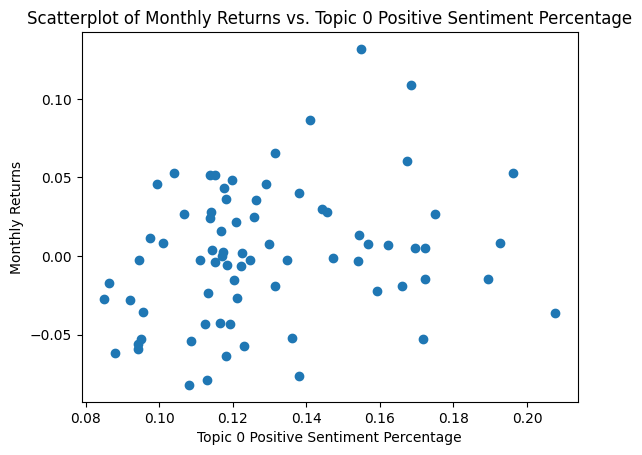

In [ ]:
import matplotlib.pyplot as plt

x_data = factor_df.iloc[:,2]
y_data = monthly_returns['return']

plt.scatter(x_data, y_data)
plt.xlabel('Topic 0 Positive Sentiment Percentage')
plt.ylabel('Monthly Returns')
plt.title('Scatterplot of Monthly Returns vs. Topic 0 Positive Sentiment Percentage')
plt.show()

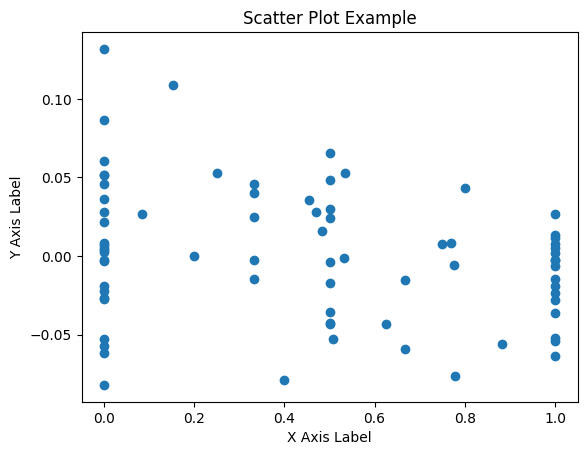

In [ ]:
import matplotlib.pyplot as plt

x_data = factor_df.iloc[:,6]
y_data = monthly_returns['return']

plt.scatter(x_data, y_data)
plt.xlabel('Topic 4 Positive Sentiment Percentage')
plt.ylabel('Monthly Returns')
plt.title('Scatterplot of Monthly Returns vs. Topic 4 Positive Sentiment Percentage')
plt.show()

# Pearson Correlation

In [ ]:
pcs = []
labels = []

for i in range(2, 13):
    x = factor_df.iloc[:,i].values
    y = monthly_returns['return'].values
    pc = np.corrcoef(x,y)
    pcs.append(round(pc[0][1],2))
    labels.append(i-2)

pc_results = pd.DataFrame({'topics': labels, 'person_corr': pcs})

In [ ]:
pc_results

,topics,person_corr
0,0,0.24
1,1,-0.11
2,2,0.20
3,3,0.02
4,4,-0.26
5,5,-0.04
6,6,0.10
7,7,-0.05
8,8,0.06
9,9,0.15


# Coefficient P-value

In [ ]:
import statsmodels.api as sm

In [ ]:
pvalues = []
labels = []

for i in range(2,13):
    X = factor_df.iloc[:,i].values
    X = sm.add_constant(X)
    y = monthly_returns['return'].values
    model = sm.OLS(y, X).fit()
    p = model.pvalues
    pvalues.append(round(p[1],2))
    labels.append(i-2)

pvalues_results = pd.DataFrame({'topics': labels, 'coef_pvalue': pvalues})

In [ ]:
pvalues_results

,topics,coef_pvalue
0,0,0.03
1,1,0.35
2,2,0.09
3,3,0.88
4,4,0.02
5,5,0.76
6,6,0.38
7,7,0.68
8,8,0.60
9,9,0.20


# RMSE

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [ ]:
# 选择用来训练的特征和目标变量
X = monthly_returns['return'].iloc[:-1].values.reshape(-1, 1)
y = monthly_returns['return'].iloc[1:].values.reshape(-1, 1)

# 拟合线性回归模型
model = LinearRegression()
model.fit(X, y)

# 均方误差
y_pred = model.predict(X)
mse_ar = mean_squared_error(y, y_pred)
rmse_ar = mse_ar ** 0.5
# print(f'Mean Squared Error: {mse_ar}')
# print(f'Root Mean Squared Error: {rmse_ar}')

rmses = []
labels = []

for i in range(2,13):
    # 选择用来训练的特征和目标变量
    X = monthly_returns['return'].iloc[:-1].values.reshape(-1, 1)
    X = np.concatenate([X, factor_df.iloc[:-1, [i]]], axis=1)
    y = monthly_returns['return'].iloc[1:].values.reshape(-1, 1)

    # 拟合线性回归模型
    model = LinearRegression()
    model.fit(X, y)

    # 均方误差
    y_pred = model.predict(X)
    mse_sp = mean_squared_error(y, y_pred)
    rmse_sp = mse_sp ** 0.5
    # print(f'Mean Squared Error: {mse_sp}')
    # print(f'Root Mean Squared Error: {rmse_sp}')

    # 计算百分比提高
    percentage_increase_sp = ((rmse_ar - rmse_sp) / rmse_ar) * 100
    rmses.append(round(percentage_increase_sp, 2))
    labels.append(i-2)

rmse_results = pd.DataFrame({'topics': labels, 'rmse_change': rmses})

In [ ]:
rmse_results

,topics,rmse_change
0,0,0.12
1,1,0.01
2,2,0.00
3,3,2.86
4,4,2.54
5,5,0.02
6,6,0.79
7,7,0.40
8,8,3.22
9,9,0.54


In [ ]:
df = pd.merge(pc_results, pvalues_results, on='topics')
df = pd.merge(df, rmse_results, on='topics')

In [ ]:
df

,topics,person_corr,coef_pvalue,rmse_change
0,0,0.24,0.03,0.12
1,1,-0.11,0.35,0.01
2,2,0.20,0.09,0.00
3,3,0.02,0.88,2.86
4,4,-0.26,0.02,2.54
5,5,-0.04,0.76,0.02
6,6,0.10,0.38,0.79
7,7,-0.05,0.68,0.40
8,8,0.06,0.60,3.22
9,9,0.15,0.20,0.54
